<a href="https://colab.research.google.com/github/estebansalas18/clasificador-imagenes/blob/main/balanceo_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import os
import io
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Barge        202 non-null    object
 1   Van          1111 non-null   object
 2   Motorcycle   2986 non-null   object
 3   Ambulance    132 non-null    object
 4   Cart         51 non-null     object
 5   Bus          2133 non-null   object
 6   Tank         206 non-null    object
 7   Truck        2033 non-null   object
 8   Helicopter   668 non-null    object
 9   Caterpillar  331 non-null    object
 10  Snowmobile   123 non-null    object
 11  Car          6781 non-null   object
 12  Boat         8695 non-null   object
 13  Segway       153 non-null    object
 14  Bicycle      1618 non-null   object
 15  Taxi         748 non-null    object
 16  Limousine    74 non-null     object
dtypes: object(17)
memory usage: 1.1+ MB


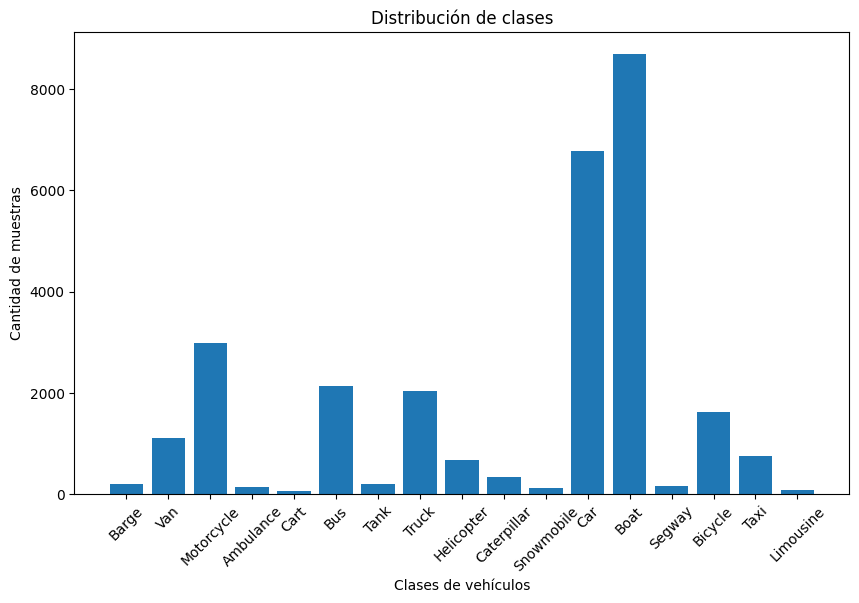

In [ ]:
# Directorio base donde se encuentran las imágenes
BASE = 'vehicle/train/train'

# Lista de clases de vehiculos
classes = ['Barge', 'Van', 'Motorcycle', 'Ambulance', 'Cart', 'Bus', 'Tank', 'Truck', 'Helicopter', 'Caterpillar', 'Snowmobile', 'Car', 'Boat', 'Segway', 'Bicycle', 'Taxi', 'Limousine']

# Crear un diccionario para almacenar los nombres de archivo de las imagenes
dataset = {}
for vehicle in classes:
    dataset[vehicle] = [i for i in os.listdir(BASE + '/' + vehicle)]
    
# Crear un DataFrame a partir del diccionario
df_original = pd.DataFrame.from_dict(dataset, orient='index')
df_original = df_original.transpose()

print("DataFrame con clases e imagenes:")
df_original.info()

# Contar la cantidad de muestras por clase en el DataFrame submuestreado
class_counts = df_original.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de vehículos')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(df_original['Boat'])

0       000002_14.jpg
1       000003_04.jpg
2       000003_09.jpg
3       000004_03.jpg
4       000004_11.jpg
            ...      
8690    005513_05.jpg
8691    005515_05.jpg
8692    005531_05.jpg
8693    005540_05.jpg
8694    005542_05.jpg
Name: Boat, Length: 8695, dtype: object


In [ ]:
# Set the path to the augmented images folder
augmented_path = "augmented"

# Create the data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Iterate over the class folders
for class_folder in ['Van', 'Bicycle']:
    BASE_path = os.path.join(BASE, class_folder)
    augmented_class_path = os.path.join(augmented_path, class_folder)
    num_augmented_images = 1000 if class_folder == 'Van' else 400
    
    # Create the folder for augmented images if it doesn't exist
    os.makedirs(augmented_class_path, exist_ok=True)
    
    # Get the list of original images in the current class folder
    images = os.listdir(BASE_path)
    
    # Copy the original images
    # Copy the original images
    for image_name in images:
        original_image_path = os.path.join(BASE_path, image_name)
        augmented_image_path = os.path.join(augmented_class_path, image_name)
        shutil.copy(original_image_path, augmented_image_path)

    
    # Augment the images to reach the desired number
    augmented_generated = 0 # Control variable

    if num_augmented_images > 0:
        for image_name in images:
            original_image_path = os.path.join(BASE_path, image_name)
            augmented_image_name = "augmented_" + image_name
            augmented_image_path = os.path.join(augmented_class_path, augmented_image_name)
            image = tf.keras.preprocessing.image.load_img(original_image_path)
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image.reshape((1,) + image.shape)
            # Generate augmented images using the data generator
            batch = datagen.flow(image, batch_size=1, save_to_dir=augmented_class_path, save_prefix="augmented_", save_format='png')
            batch.next()
            augmented_generated += 1
            if augmented_generated == num_augmented_images:
                break

DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VanA        2064 non-null   object
 1   Motorcycle  2986 non-null   object
 2   Bus         2133 non-null   object
 3   Truck       2033 non-null   object
 4   Car         6781 non-null   object
 5   Boat        8695 non-null   object
 6   BicycleA    2013 non-null   object
dtypes: object(7)
memory usage: 475.6+ KB


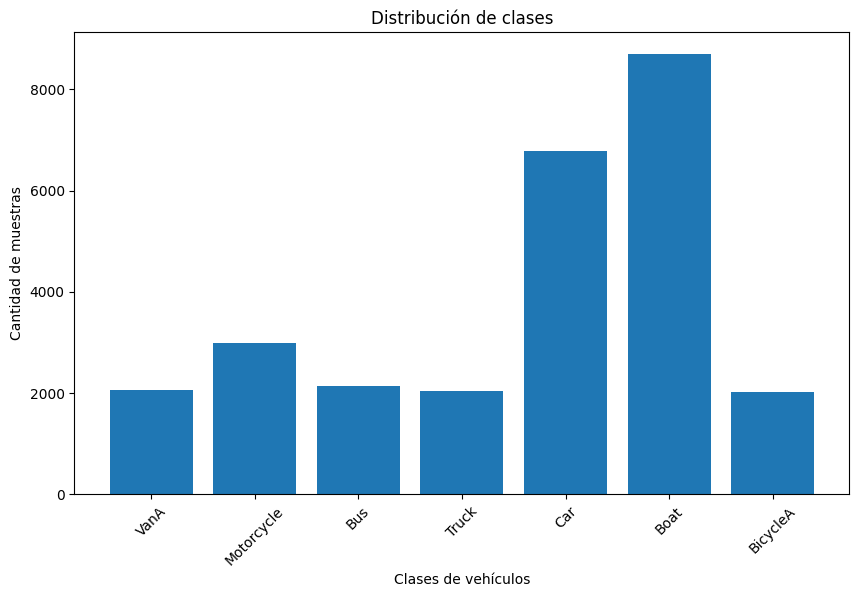

In [ ]:
classes = [
    'VanA',
    'Motorcycle',
    'Bus',
    'Truck',
    'Car',
    'Boat',
    'BicycleA',
]

oversampled_data_dict = {}
for vehicle in classes:
    oversampled_data_dict[vehicle] = [i for i in os.listdir(BASE + '/' + vehicle)]
    
# Crear un DataFrame a partir del diccionario
df_oversampled = pd.DataFrame.from_dict(oversampled_data_dict, orient='index')
df_oversampled = df_oversampled.transpose()

print("DataFrame con clases e imagenes:")
df_oversampled.info()

# Contar la cantidad de muestras por clase en el DataFrame sobremuestreado
class_counts = df_oversampled.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de vehículos')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VanA        2064 non-null   object
 1   Motorcycle  2200 non-null   object
 2   Bus         2133 non-null   object
 3   Truck       2033 non-null   object
 4   Car         2200 non-null   object
 5   Boat        2200 non-null   object
 6   BicycleA    2013 non-null   object
dtypes: object(7)
memory usage: 120.4+ KB


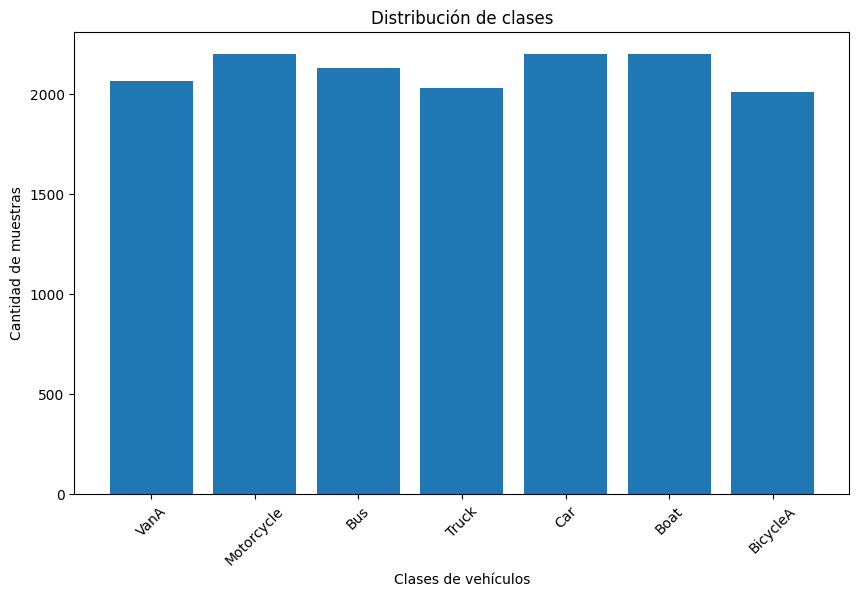

In [ ]:
classes = [
    'VanA',
    'Motorcycle',
    'Bus',
    'Truck',
    'Car',
    'Boat',
    'BicycleA',
]

# Crear el diccionario de muestras submuestreadas por clase
undersampled_data_dict = {}
max_samples = 2200 # Obtener el número máximo de muestras en clases desbalanceadas

for vehicle in classes:
    class_samples = df_oversampled[vehicle].dropna().tolist()
    if len(class_samples) > max_samples:
        random_indices = np.random.choice(len(class_samples), size=max_samples, replace=False)
        class_samples = [class_samples[i] for i in random_indices]
    undersampled_data_dict[vehicle] = class_samples

# Crear el DataFrame con las muestras submuestreadas
df = pd.DataFrame.from_dict(undersampled_data_dict, orient='index')
df = df.transpose()

print("DataFrame con clases e imagenes:")
df.info()

# Contar la cantidad de muestras por clase en el DataFrame submuestreado
class_counts = df.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de vehículos')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Ejemplo de el proceso de submuestreo, en donde se ve que las imagenes se eliminaron aleatoriamente
print(df['Boat'])

0       004091_05.jpg
1       002150_02.jpg
2       003411_02.jpg
3       000282_15.jpg
4       002417_01.jpg
            ...      
2195    003784_05.jpg
2196    001179_10.jpg
2197    004106_01.jpg
2198    003140_04.jpg
2199    002652_17.jpg
Name: Boat, Length: 2200, dtype: object


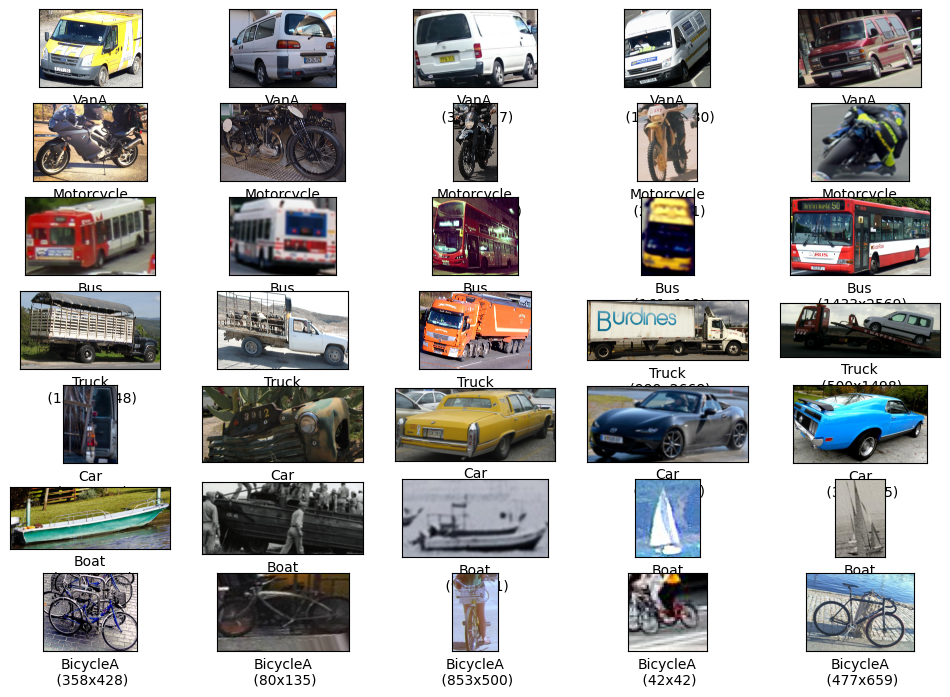

In [ ]:
# Showing radom images from each class in dataset
plt.figure(figsize=(12,12))
count = 0
for i, cls in enumerate(classes):
  for j in range(5):
    dir = f'vehicle/train/train/{cls}'
    filename = random.choice(df[cls].dropna())
    path = os.path.join(dir, filename)
    img = plt.imread(path)
    count += 1
    plt.subplot(10,5,count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(f'{cls}\n ({img.shape[0]}x{img.shape[1]})')

plt.show()
